![Under Maintenance](https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExeHNuZWxoMHZheXZ6NXp0aGRlYnhucGcybXA2NWNlem5iZ3J2a2I1aSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/7ZoMAYSgQJ8oe5gCYE/giphy.gif)

# Understanding and Solving Overfitting in Deep Learning

## 🎯 What You'll Learn
In this notebook, we'll explore:
1. What overfitting is and why it happens
2. How to intentionally create overfitting (to understand it better)
3. How to fix it using **Dropout**
4. How to fix it using **Batch Normalization**
5. How to combine both techniques

---

## 📚 What is Overfitting?

**Simple Explanation:**
Imagine you're studying for an exam by memorizing practice questions and their answers. You get 100% on practice tests, but when the real exam comes with slightly different questions, you fail!

This is **overfitting**: Your model memorizes the training data perfectly but can't handle new, unseen data.

**Signs of Overfitting:**
- ✅ Training accuracy: 99%
- ❌ Test accuracy: 65%
- The model is too focused on specific details in training data

---

In [4]:
# First, let's import all the libraries we need

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility (so we get the same results each time)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [5]:
# Load the MNIST dataset (handwritten digits 0-9)
# This is a classic dataset for learning deep learning

# Transform: Convert images to tensors and normalize them
# Normalization helps the model learn faster
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST dataset
])

# Download and load training data
train_dataset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)

# Create data loaders (they feed data to the model in small batches)
batch_size = 64  # Process 64 images at a time
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Test samples: 10000
Batches per epoch: 938


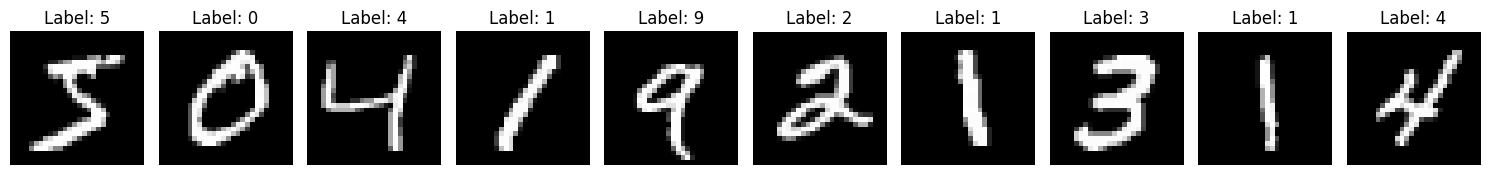

In [6]:
# Let's visualize some examples from the dataset

def show_samples(dataset, n_samples=10):
    plt.figure(figsize=(15, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        image, label = dataset[i]
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

### 💡 What we see

These are the actual images our model will learn from! Each is 28x28 pixels (very small). The goal is to teach the model to recognize which digit each image represents.

---

## 🔴 Model 1: Creating Overfitting (The Problem)

Let's intentionally create a model that overfits. We'll make it **too complex** for the task, so it memorizes rather than learns patterns.

**How we create overfitting:**
1. Make the network very deep (many layers)
2. Use many neurons (high capacity to memorize)
3. Train for many epochs (give it time to memorize)

In [7]:
class OverfittingModel(nn.Module):
    """A model designed to overfit -- to many parameters!"""

    def __init__(self):
        super(OverfittingModel, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        """This defines how data flows through the network."""
        x = x.view(-1, 784)  # Flatten the 28x28 image into a 784-dimensional vector
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # Output layer (no activation here, we'll use CrossEntropyLoss which applies softmax)
        return x

In [8]:
overfit_model = OverfittingModel().to(device)

In [9]:
total_params = sum(p.numel() for p in overfit_model.parameters())
print(f"Total number of parameters in the overfitting model: {total_params}")
print(f"Number of parameters in the input layer: {overfit_model.fc1.weight.numel()}")
print(f"Model architecture:\n{overfit_model}")

Total number of parameters in the overfitting model: 1195018
Number of parameters in the input layer: 401408
Model architecture:
OverfittingModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


### 💡 Understanding the Model

**What's happening:**
- **nn.Linear(784, 512)**: A layer that connects 784 inputs to 512 neurons. Each connection has a weight (parameter) the model learns.
- **ReLU**: "Rectified Linear Unit" - a simple function that helps the model learn complex patterns. Think of it as a decision: if input > 0, keep it; else, make it 0.
- **Parameters**: Over 1 million! This is way too many for recognizing simple digits. It's like using a supercomputer to add 2+2.

**Why this overfits:**
With so many parameters, the model can memorize every single training image instead of learning general patterns.

---

In [10]:
# Training function - this is how the model learns

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch (one pass through all training data)"""
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move data to GPU/CPU
        images, labels = images.to(device), labels.to(device)
        
        # 1. Zero the gradients (clear previous step's learning)
        optimizer.zero_grad()
        
        # 2. Forward pass: make predictions
        outputs = model(images)
        
        # 3. Calculate loss (how wrong are the predictions?)
        loss = criterion(outputs, labels)
        
        # 4. Backward pass: calculate gradients (which direction to adjust weights)
        loss.backward()
        
        # 5. Update weights using the optimizer
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

### 💡 How Training Works

**The Learning Loop:**
1. **Forward Pass**: Show the model an image, it makes a prediction
2. **Loss Calculation**: Compare prediction to the correct answer. How wrong was it?
3. **Backward Pass**: Calculate how to adjust each weight to reduce the error
4. **Weight Update**: Actually adjust the weights a tiny bit
5. **Repeat**: Do this for all 60,000 images

**Key Concepts:**
- **Optimizer**: The algorithm that decides how to update weights (we'll use Adam - a popular choice)
- **Loss Function**: Measures how wrong the model is (CrossEntropyLoss for classification)
- **Gradients**: The direction and amount to adjust each weight

---

In [11]:
# Evaluation function - check how well the model performs

def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test data"""
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Don't calculate gradients (saves memory and time)
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc

In [12]:
# Train the overfitting model

print("🔴 Training Model 1: Overfitting Model\n" + "="*50)

# Setup training
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(overfit_model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Track history
overfit_history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

n_epochs = 20  # Train for 20 complete passes through the data

for epoch in range(n_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(overfit_model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test data
    test_loss, test_acc = evaluate(overfit_model, test_loader, criterion, device)
    
    # Save history
    overfit_history['train_loss'].append(train_loss)
    overfit_history['train_acc'].append(train_acc)
    overfit_history['test_loss'].append(test_loss)
    overfit_history['test_acc'].append(test_acc)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.2f}%")
        print(f"  Gap: {train_acc - test_acc:.2f}%")  # The overfitting gap!
        print()

print("Training complete!")

🔴 Training Model 1: Overfitting Model
Epoch [5/20]
  Train Loss: 0.0554, Train Acc: 98.39%
  Test Loss:  0.0772, Test Acc:  97.92%
  Gap: 0.47%

Epoch [10/20]
  Train Loss: 0.0305, Train Acc: 99.16%
  Test Loss:  0.0824, Test Acc:  98.20%
  Gap: 0.96%

Epoch [15/20]
  Train Loss: 0.0248, Train Acc: 99.37%
  Test Loss:  0.0906, Test Acc:  98.23%
  Gap: 1.14%

Epoch [20/20]
  Train Loss: 0.0136, Train Acc: 99.66%
  Test Loss:  0.1335, Test Acc:  97.91%
  Gap: 1.75%

Training complete!


### 💡 Observing Overfitting

**What to watch for:**
- **Train Accuracy**: Should get very high (95%+)
- **Test Accuracy**: Will be noticeably lower
- **The Gap**: The difference between train and test accuracy shows overfitting

**Example of overfitting:**
- Train Acc: 99.66% ← Model is great on training data
- Test Acc: 97.91% ← But worse on new data
- Gap: 1.75% ← This is the overfitting!

A small gap is normal and okay. A large gap means the model memorized instead of learning.

---

C:\Users\bengu\AppData\Local\Temp\ipykernel_27296\3841154982.py:26: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\codes\testPytorch\env1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


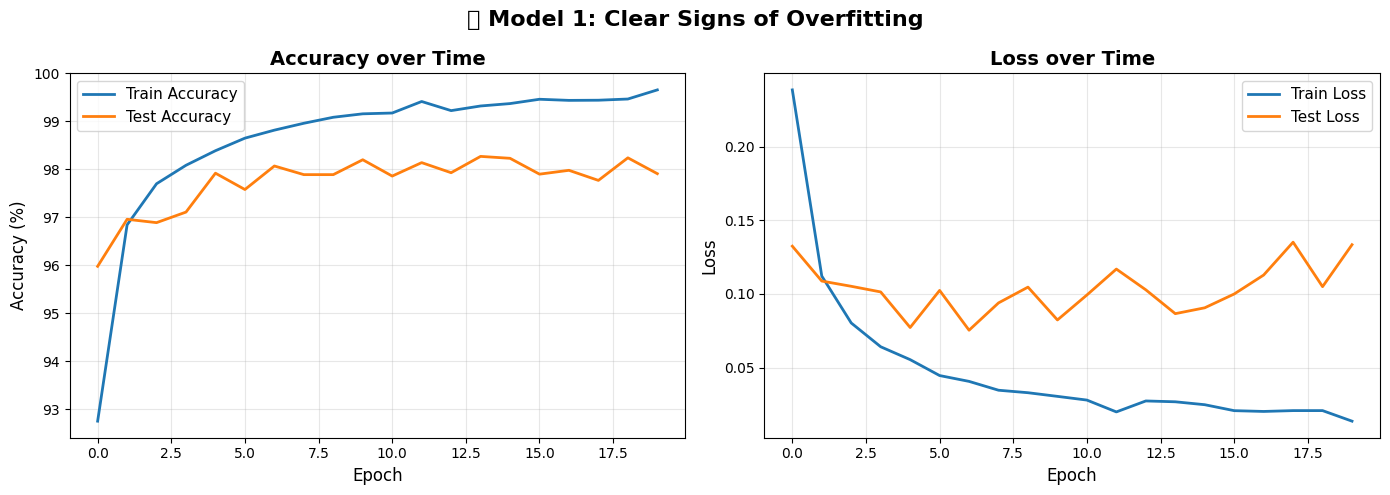

In [13]:
# Visualize the overfitting

def plot_training_history(history, title):
    """Plot training and test accuracy/loss over time"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax1.plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Accuracy over Time', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax2.plot(history['test_loss'], label='Test Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Loss over Time', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(overfit_history, '🔴 Model 1: Clear Signs of Overfitting')